# Día 7: Práctica - Análisis de Causalidad en Series Temporales

En este notebook haremos:
1. Preparación de un dataset multivariable.
2. Test de causalidad de Granger.
3. (Opcional) Ajuste de un modelo VAR y verificación de causality en entorno multivariado.
4. Discusión de resultados y conclusiones.


In [2]:
# Sección 0: Importaciones

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para Granger Causality
from statsmodels.tsa.stattools import grangercausalitytests
# Para VAR
from statsmodels.tsa.api import VAR

%matplotlib inline
sns.set_style('whitegrid')

print("Entorno preparado para causalidad.")


Entorno preparado para causalidad.


## Sección 1: Carga (o creación) de datos multivariable

Ejemplo: dos variables relacionadas, por ejemplo 'precio' y 'ventas'.


In [3]:
# Generamos datos sintéticos (1 año diario)
np.random.seed(42)
date_range = pd.date_range(start='2025-01-01', periods=365, freq='D')

# Supongamos que 'precio' fluctúa con una tendencia y ruido
precio = 50 + np.linspace(0, 5, 365) + np.random.normal(0, 1, 365)

# 'ventas' depende del 'precio' (si precio sube, ventas baja un poco), más estacionalidad semanal
ventas = 300 - 2*precio + 10 * np.sin(2*np.pi*np.arange(365)/7) + np.random.normal(0, 5, 365)

df = pd.DataFrame({'precio': precio, 'ventas': ventas}, index=date_range)
df.head()


,precio,ventas
2025-01-01,50.496714,197.000469
2025-01-02,49.875472,209.187833
2025-01-03,50.675161,208.461919
2025-01-04,51.564239,201.698741
2025-01-05,49.820792,192.154530


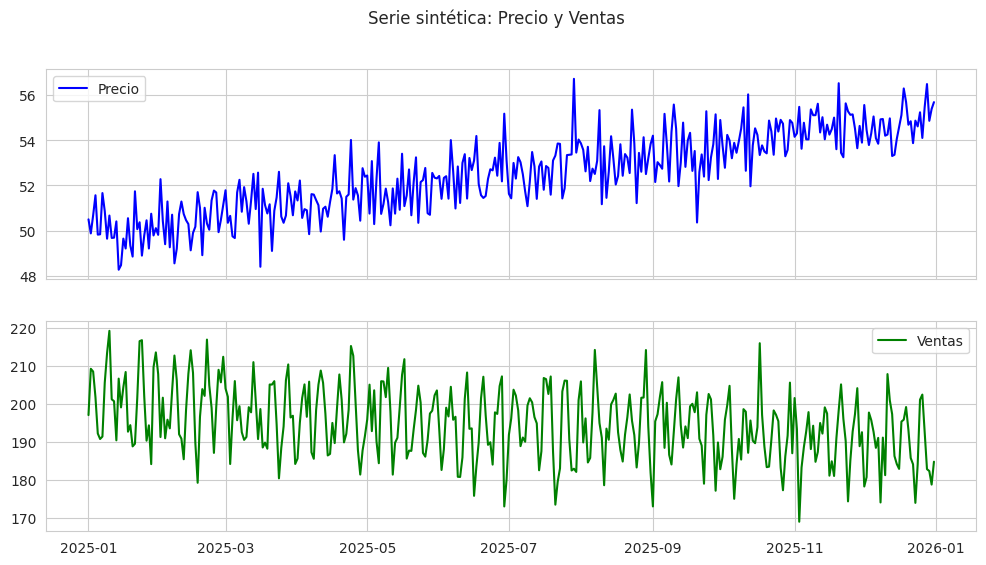

In [4]:
# Visualización
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax[0].plot(df.index, df['precio'], label='Precio', color='blue')
ax[0].legend()
ax[1].plot(df.index, df['ventas'], label='Ventas', color='green')
ax[1].legend()
plt.suptitle("Serie sintética: Precio y Ventas")
plt.show()


## Sección 2: Test de Causalidad de Granger

### 2.1. Preparación
- Revisar estacionariedad (opcional).
- Decidir un 'maxlag' (ej. 7 días).


In [5]:
max_lag = 7

# Granger tests: La función requiere un array con la forma [Y, X]
# Por convención, el primer col es la variable "dependiente".
# Queremos ver si 'precio' Granger causa 'ventas'.

data_for_test = df[['ventas', 'precio']].dropna()  # [Y=ventas, X=precio]
grangercausalitytests(data_for_test, maxlag=max_lag, addconst=True, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5083  , p=0.0619  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=3.5375  , p=0.0600  , df=1
likelihood ratio test: chi2=3.5204  , p=0.0606  , df=1
parameter F test:         F=3.5083  , p=0.0619  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.1832 , p=0.0000  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=40.9301 , p=0.0000  , df=2
likelihood ratio test: chi2=38.7826 , p=0.0000  , df=2
parameter F test:         F=20.1832 , p=0.0000  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.2338 , p=0.0000  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=89.4309 , p=0.0000  , df=3
likelihood ratio test: chi2=79.9217 , p=0.0000  , df=3
parameter F test:         F=29.2338 , p=0.0000  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=36.8557 , p=0.0000  

/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (3.5083074715358262, 0.06186972226970595, 361.0, 1),
   'ssr_chi2test': (3.537462381271581, 0.05999718602926122, 1),
   'lrtest': (3.5203838754514436, 0.060618405848921544, 1),
   'params_ftest': (3.5083074715361677, 0.061869722269692236, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (20.18317852902626, 4.9484214067905905e-09, 358.0, 2),
   'ssr_chi2test': (40.9301329946175, 1.2945968573731708e-09, 2),
   'lrtest': (38.78258989093683, 3.788502762153554e-09, 2),
   'params_ftest': (20.18317852902673, 4.948421406788516e-09, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (29.233848313808227, 6.487613964001299e-17, 355.0, 3),
   'ssr_chi2test': (89.43087117970629, 2.902646290377169e-19, 3),
   'lrtest': (79.92165050618087, 3.190376157482081e-17, 3),
   'params_ftest': (29.23384831380818, 6.487613964001437e-17, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


**Interpretación**:
- Para cada lag, se calcula un F-test y una p-value.
- Si la p-value es muy baja en alguno de los lags, podemos concluir que "precio" Granger causa "ventas".

### 2.2. Invertimos roles: ¿Ventas causa Precio?


In [6]:
# [Y=precio, X=ventas]
data_for_test_inv = df[['precio', 'ventas']].dropna()
grangercausalitytests(data_for_test_inv, maxlag=max_lag, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5579  , p=0.4556  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.5626  , p=0.4532  , df=1
likelihood ratio test: chi2=0.5621  , p=0.4534  , df=1
parameter F test:         F=0.5579  , p=0.4556  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2710  , p=0.0391  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=6.6334  , p=0.0363  , df=2
likelihood ratio test: chi2=6.5735  , p=0.0374  , df=2
parameter F test:         F=3.2710  , p=0.0391  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5741  , p=0.0538  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=7.8746  , p=0.0487  , df=3
likelihood ratio test: chi2=7.7901  , p=0.0506  , df=3
parameter F test:         F=2.5741  , p=0.0538  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1826  , p=0.0705  

/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.557918411300736, 0.45558636142786135, 361.0, 1),
   'ssr_chi2test': (0.562554852391878, 0.4532326814480564, 1),
   'lrtest': (0.5621205910235858, 0.4534070838978018, 1),
   'params_ftest': (0.5579184113012055, 0.45558636142768294, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.2709985223841054, 0.03910632662990459, 358.0, 2),
   'ssr_chi2test': (6.633365718577823, 0.03627295490663167, 2),
   'lrtest': (6.573485920580879, 0.03737538447788671, 2),
   'params_ftest': (3.27099852238444, 0.039106326629891316, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.5740965727928082, 0.05382160519073255, 355.0, 3),
   'ssr_chi2test': (7.874560219867576, 0.048676568417819845, 3),
   'lrtest': (7.790134982806421, 0.05055406495379535, 3),
   'params_ftest': (2.5740965727929495, 0.05382160519072156, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

Observamos si hay causalidad inversa.  
Si hallamos que precio causa ventas, y no viceversa, indicaría una relación unidireccional (o un lead-lag).

---
## Sección 3: Modelo VAR (Opcional)

Ajustamos un Vector Autoregression con 'precio' y 'ventas' para ver las interdependencias.


In [7]:
model_var = VAR(df[['precio','ventas']].dropna())
results_var = model_var.fit(maxlags=7, ic='aic')
print(results_var.summary())

# Ver información de las ecuaciones
results_var.test_causality('precio', ['ventas'], kind='f')
results_var.test_causality('ventas', ['precio'], kind='f')


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Feb, 2025
Time:                     10:41:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.90996
Nobs:                     358.000    HQIC:                   3.71410
Log likelihood:          -1627.63    FPE:                    36.0488
AIC:                      3.58477    Det(Omega_mle):         33.2077
--------------------------------------------------------------------
Results for equation precio
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            17.217440         8.822978            1.951           0.051
L1.precio         0.027011         0.057861            0.467           0.641
L1.ventas        -0.022794         0.009158           -2.489           0.01

La salida `test_causality` en `statsmodels` nos permite ver resultados similares a Granger, pero en un marco VAR.

---
## Sección 4: Discusión de Resultados

- Verifica si hay bidireccionalidad o unidireccionalidad.
- Ten en cuenta la magnitud de p-values y el lag donde se encuentra la relación más fuerte.

---
## Sección 5: Conclusiones y Cierre

1. **Granger** es una forma de estimar relaciones causales en el contexto de series temporales, aunque no garantiza causalidad “real”.
2. **Extensión a multivariables** con VAR en statsmodels.
3. **Reflexión final**: Sin un diseño experimental o variables de control, la interpretación debe ser cauta.

¡Fin del Notebook y del curso!


Espacio final de preguntas:
Permite que los alumnos traigan dudas de cualquier tema visto: ARIMA, SARIMA, ML supervisado, anomalías, causalidad.
Recapitulación:
Muestra un resumen de los objetivos alcanzados y las tareas clave realizadas.
Ofrece consejos para continuar formándose (libros, cursos online, bibliografía).
Agradecimientos:
Motiva a los participantes a seguir practicando y compartiendo sus proyectos.
Conclusión
Con este plan para el Día 7:

Proporcionarás a tus alumnos nociones de causalidad en series temporales, especialmente con la Prueba de Granger y la estructura VAR.
Concluirás el curso haciendo un repaso global de todo lo aprendido, destacando la importancia de la interpretación y dejando abierta la puerta a enfoques más avanzados de causal inference.
¡Éxitos en tu última sesión y en el cierre del curso!